# **Import Libraries & Load Data**

In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#Files
path='/kaggle/input/chest-xray-pneumonia/chest_xray'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0  chest_xray
1    __MACOSX
2         val
3        test
4       train

In [3]:
#The Image Count In Folders
dict_={'train':[],'test':[],'val':[]}
for i in tqdm(['train','test','val']):
    path_=os.path.join(path,i)
    for j in os.listdir(path_):
        dict_[i].append(len(os.listdir(os.path.join(path_,j))))
pd.DataFrame(dict_,index=os.listdir(path_))

100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


train  test  val
PNEUMONIA   3875   390    8
NORMAL      1341   234    8

In [4]:
#Size
def Size(folder):
    size=[]
    path_=os.path.join(path,folder)
    for i in tqdm(os.listdir(path_)):
        path2=os.path.join(path_,i)
        for j in os.listdir(path2):
            img=cv2.imread(os.path.join(path2,j))
            size.append(img.shape)
    return pd.Series(size)

In [5]:
#train
Size('train')

100%|██████████| 2/2 [01:44<00:00, 52.02s/it]


0        (712, 1024, 3)
1       (1016, 1424, 3)
2       (1208, 1376, 3)
3       (1256, 1336, 3)
4         (516, 895, 3)
             ...       
5211    (2326, 2091, 3)
5212    (1136, 1484, 3)
5213    (1430, 1762, 3)
5214    (1067, 1316, 3)
5215    (1272, 1592, 3)
Length: 5216, dtype: object

In [6]:
#test
Size('test')

100%|██████████| 2/2 [00:11<00:00,  5.70s/it]


0      (1104, 1624, 3)
1       (784, 1120, 3)
2       (712, 1096, 3)
3        (520, 984, 3)
4       (568, 1048, 3)
            ...       
619     (890, 1450, 3)
620    (1016, 1432, 3)
621    (1731, 2226, 3)
622    (1454, 1611, 3)
623    (1478, 1873, 3)
Length: 624, dtype: object

In [7]:
#val
Size('val')

100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


0      (664, 1152, 3)
1      (712, 1072, 3)
2      (952, 1192, 3)
3     (1128, 1664, 3)
4      (656, 1016, 3)
5       (592, 968, 3)
6      (944, 1416, 3)
7      (864, 1256, 3)
8     (1416, 1736, 3)
9     (1225, 1632, 3)
10    (1302, 1564, 3)
11    (1416, 1776, 3)
12    (1040, 1272, 3)
13     (928, 1288, 3)
14    (1104, 1328, 3)
15    (1104, 1240, 3)
dtype: object

In [8]:
Size=80
images=[]
labels=[]
def load():
    global images
    global labels
    for folder in tqdm(['train','test','val']):
        path_=os.path.join(path,folder)
        for files in os.listdir(path_):
            path2=os.path.join(path_,files)
            for img in os.listdir(path2):
                image=cv2.imread(os.path.join(path2,img))
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,(Size,Size))
                image=image/255.0
                images.append(image)
                labels.append(files)      
load()
images=np.array(images)
labels=np.array(labels)

100%|██████████| 3/3 [01:18<00:00, 26.08s/it]


In [9]:
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (5856, 80, 80, 3)
Labels Shape : (5856,)


In [10]:
labels[0]

'PNEUMONIA'

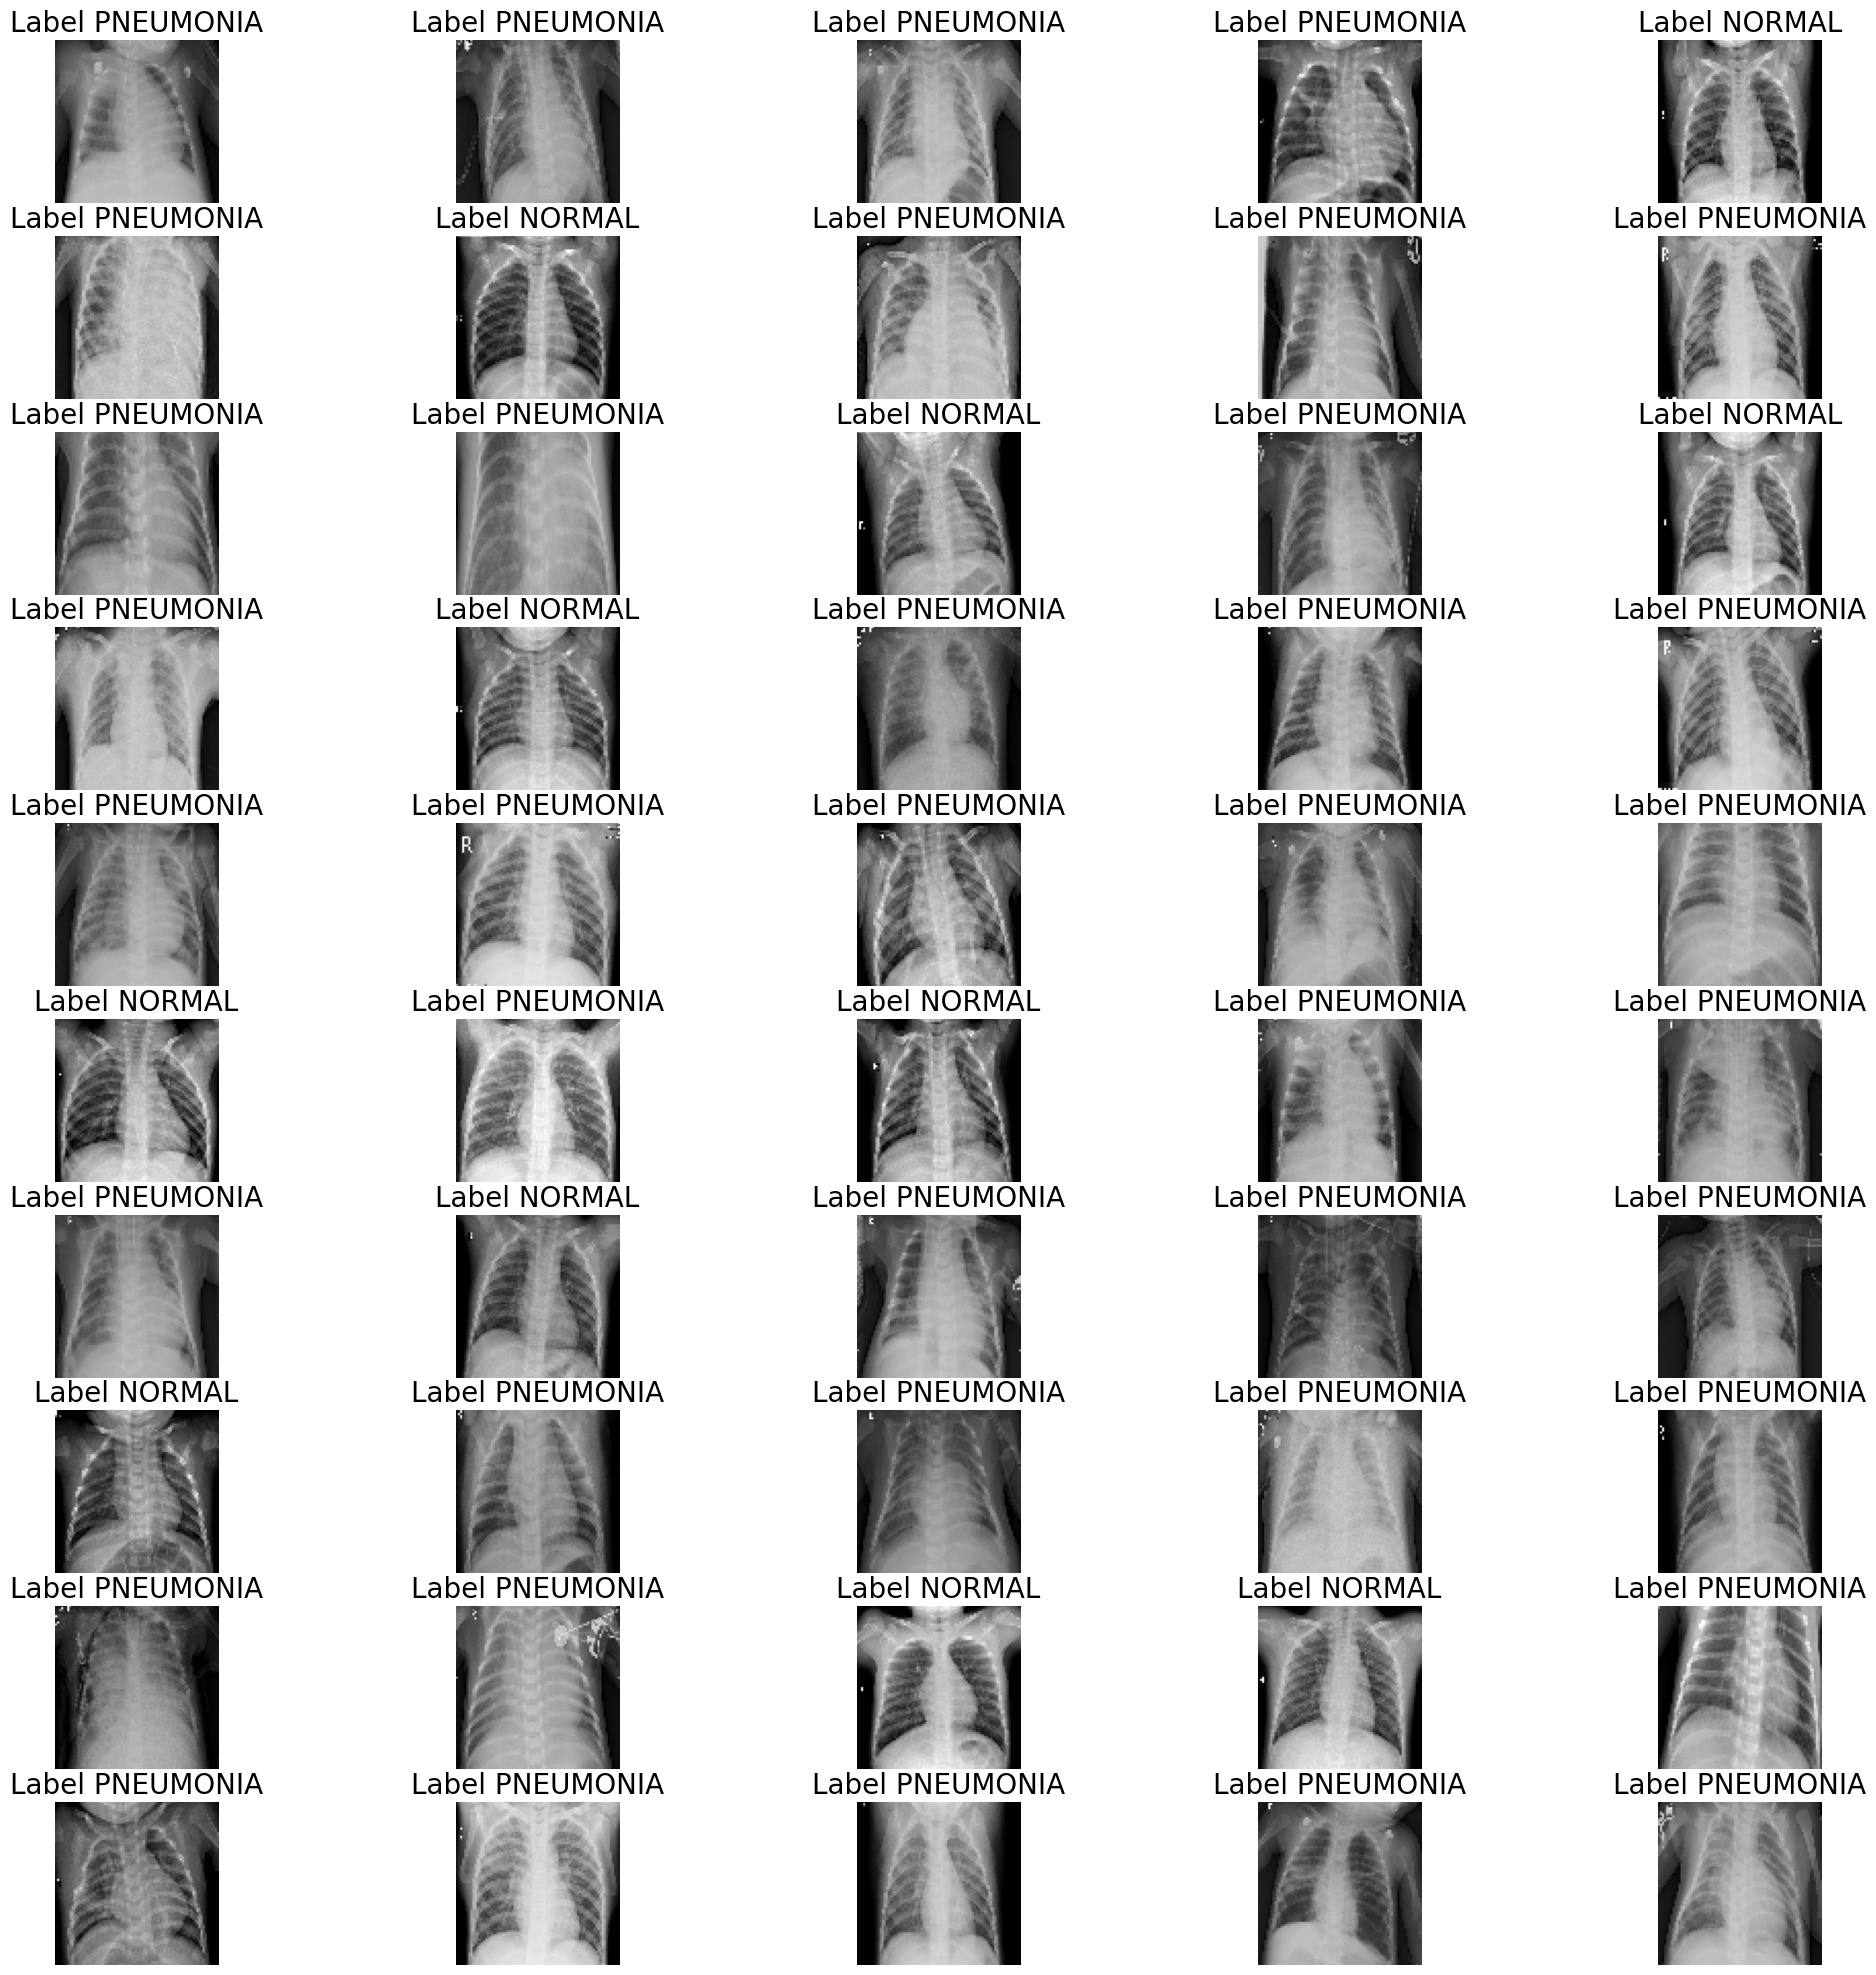

In [11]:
#Show
plt.figure(figsize=(25,25))
x = 1
for i in np.random.randint(0,len(images),50):
    plt.subplot(10, 5, x)
    plt.imshow(images[i])
    plt.title(f'Label {labels[i]}', fontsize=20)
    plt.axis('off')    
    x += 1

In [12]:
label=LabelEncoder()
labels=label.fit_transform(labels)
labels

array([1, 1, 1, ..., 0, 0, 0])

In [13]:
X_train, X_test2, y_train, y_test2 = train_test_split(images, labels, test_size=0.30, random_state=44, shuffle =True)
X_val, X_test, y_val, y_test = train_test_split(X_test2, y_test2, test_size=0.50, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_val shape is ' , X_val.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_val shape is ' , y_val.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4099, 80, 80, 3)
X_val shape is  (878, 80, 80, 3)
X_test shape is  (879, 80, 80, 3)
y_train shape is  (4099,)
y_val shape is  (878,)
y_test shape is  (879,)


In [14]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(Size,Size,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3)))  
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu)) 
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(128,activation=tf.nn.relu)) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 78, 78, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                        

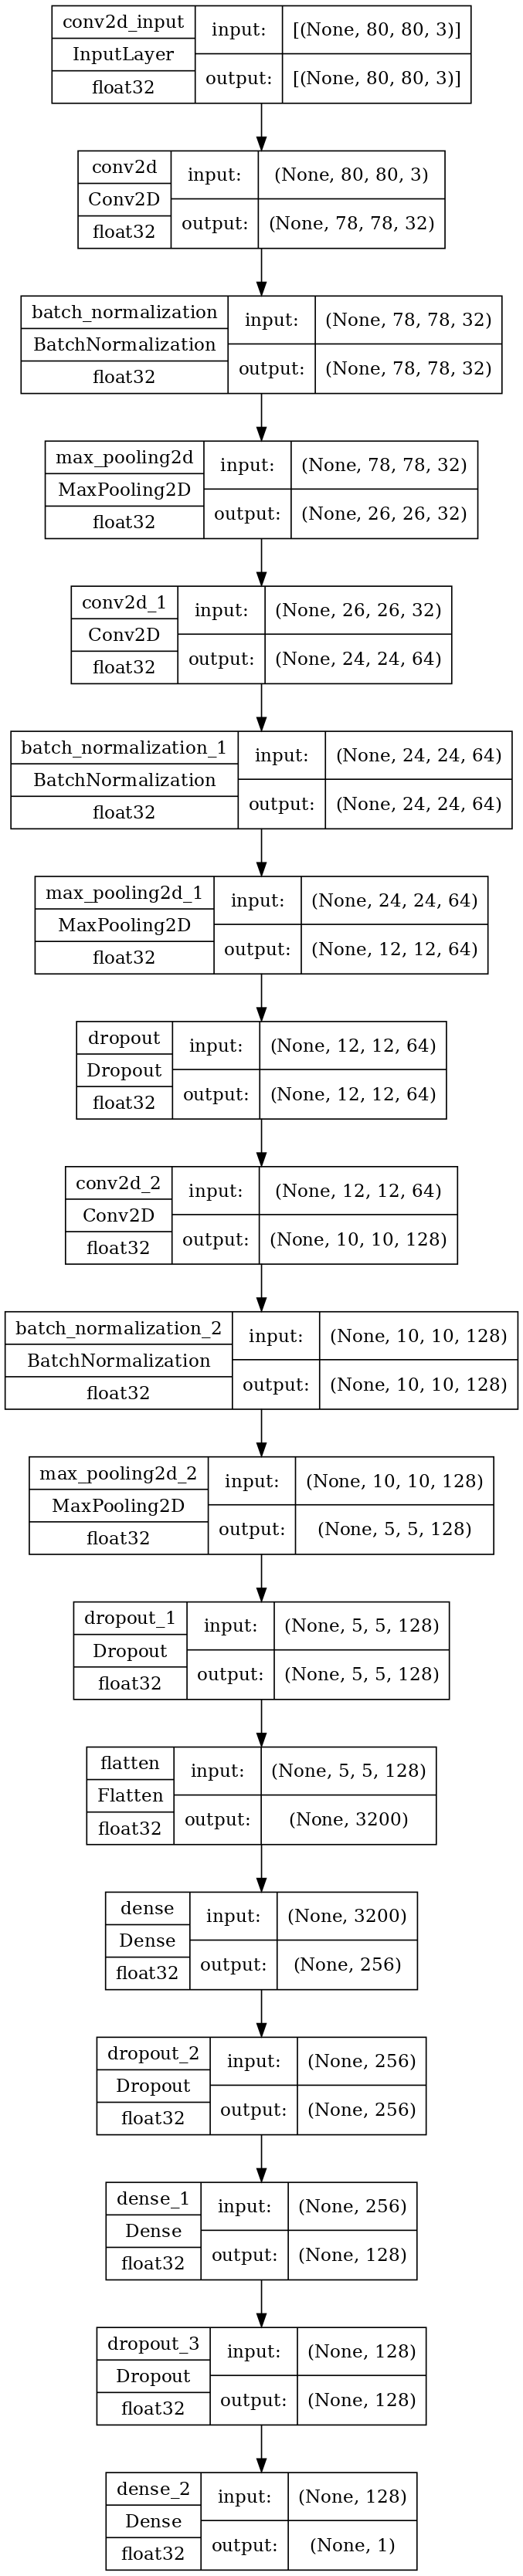

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [17]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10


2023-08-24 22:12:47.804997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


129/129 [==============================] - 14s 19ms/step - loss: 0.3833 - accuracy: 0.8712 - val_loss: 2.3599 - val_accuracy: 0.7642
Epoch 2/10
129/129 [==============================] - 2s 12ms/step - loss: 0.2310 - accuracy: 0.9097 - val_loss: 3.7451 - val_accuracy: 0.7642
Epoch 3/10
129/129 [==============================] - 2s 12ms/step - loss: 0.1652 - accuracy: 0.9397 - val_loss: 0.2943 - val_accuracy: 0.8918
Epoch 4/10
129/129 [==============================] - 2s 13ms/step - loss: 0.1443 - accuracy: 0.9502 - val_loss: 0.7703 - val_accuracy: 0.7779
Epoch 5/10
129/129 [==============================] - 2s 12ms/step - loss: 0.1363 - accuracy: 0.9488 - val_loss: 0.2895 - val_accuracy: 0.9180
Epoch 6/10
129/129 [==============================] - 2s 12ms/step - loss: 0.1295 - accuracy: 0.9527 - val_loss: 0.0899 - val_accuracy: 0.9681
Epoch 7/10
129/129 [==============================] - 2s 12ms/step - loss: 0.1326 - accuracy: 0.9515 - val_loss: 0.5648 - val_accuracy: 0.7426
Epoch 8/1

In [18]:
score, acc = model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

28/28 [==============================] - 0s 9ms/step - loss: 0.2536 - accuracy: 0.9113
Test Loss = 0.2535944879055023
Test Accuracy = 0.9112628102302551


In [19]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.383290  0.871188  2.359879      0.764237
1  0.230956  0.909734  3.745129      0.764237
2  0.165213  0.939741  0.294282      0.891800
3  0.144273  0.950232  0.770333      0.777904
4  0.136302  0.948768  0.289529      0.917995
5  0.129515  0.952671  0.089856      0.968109
6  0.132561  0.951452  0.564828      0.742597
7  0.108523  0.958770  1.180742      0.782460
8  0.125550  0.952183  0.301609      0.878132
9  0.097360  0.966333  0.296583      0.892938

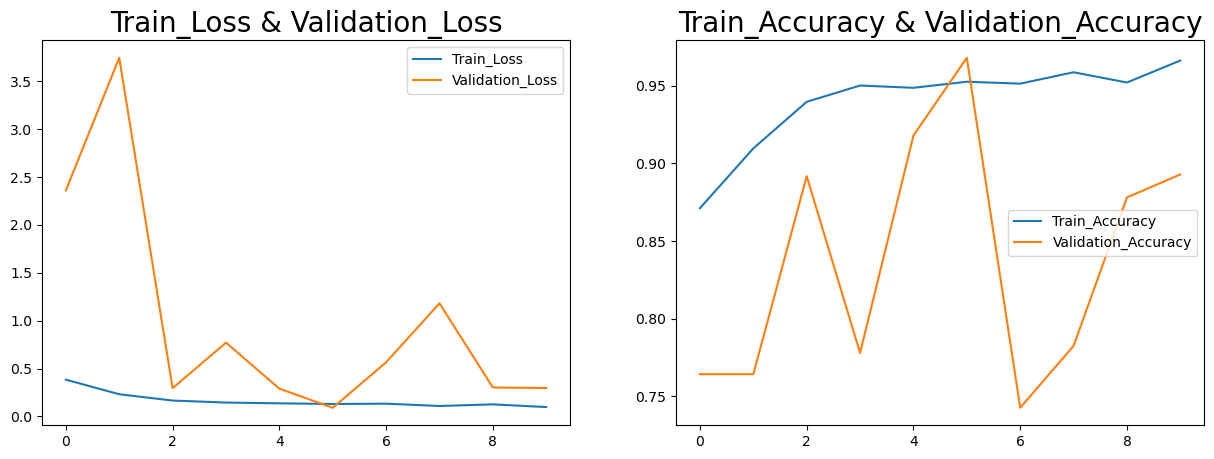

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [21]:
prediction = model.predict(X_test)
prediction[0]

28/28 [==============================] - 0s 3ms/step


array([0.9397054], dtype=float32)

In [22]:
y_pred=np.where(prediction>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=label.inverse_transform(y_test),label.inverse_transform(y_pred)
df

Actual Prediction
0    PNEUMONIA  PNEUMONIA
1    PNEUMONIA     NORMAL
2       NORMAL     NORMAL
3    PNEUMONIA  PNEUMONIA
4    PNEUMONIA  PNEUMONIA
..         ...        ...
874  PNEUMONIA  PNEUMONIA
875  PNEUMONIA  PNEUMONIA
876     NORMAL     NORMAL
877     NORMAL     NORMAL
878     NORMAL     NORMAL

[879 rows x 2 columns]

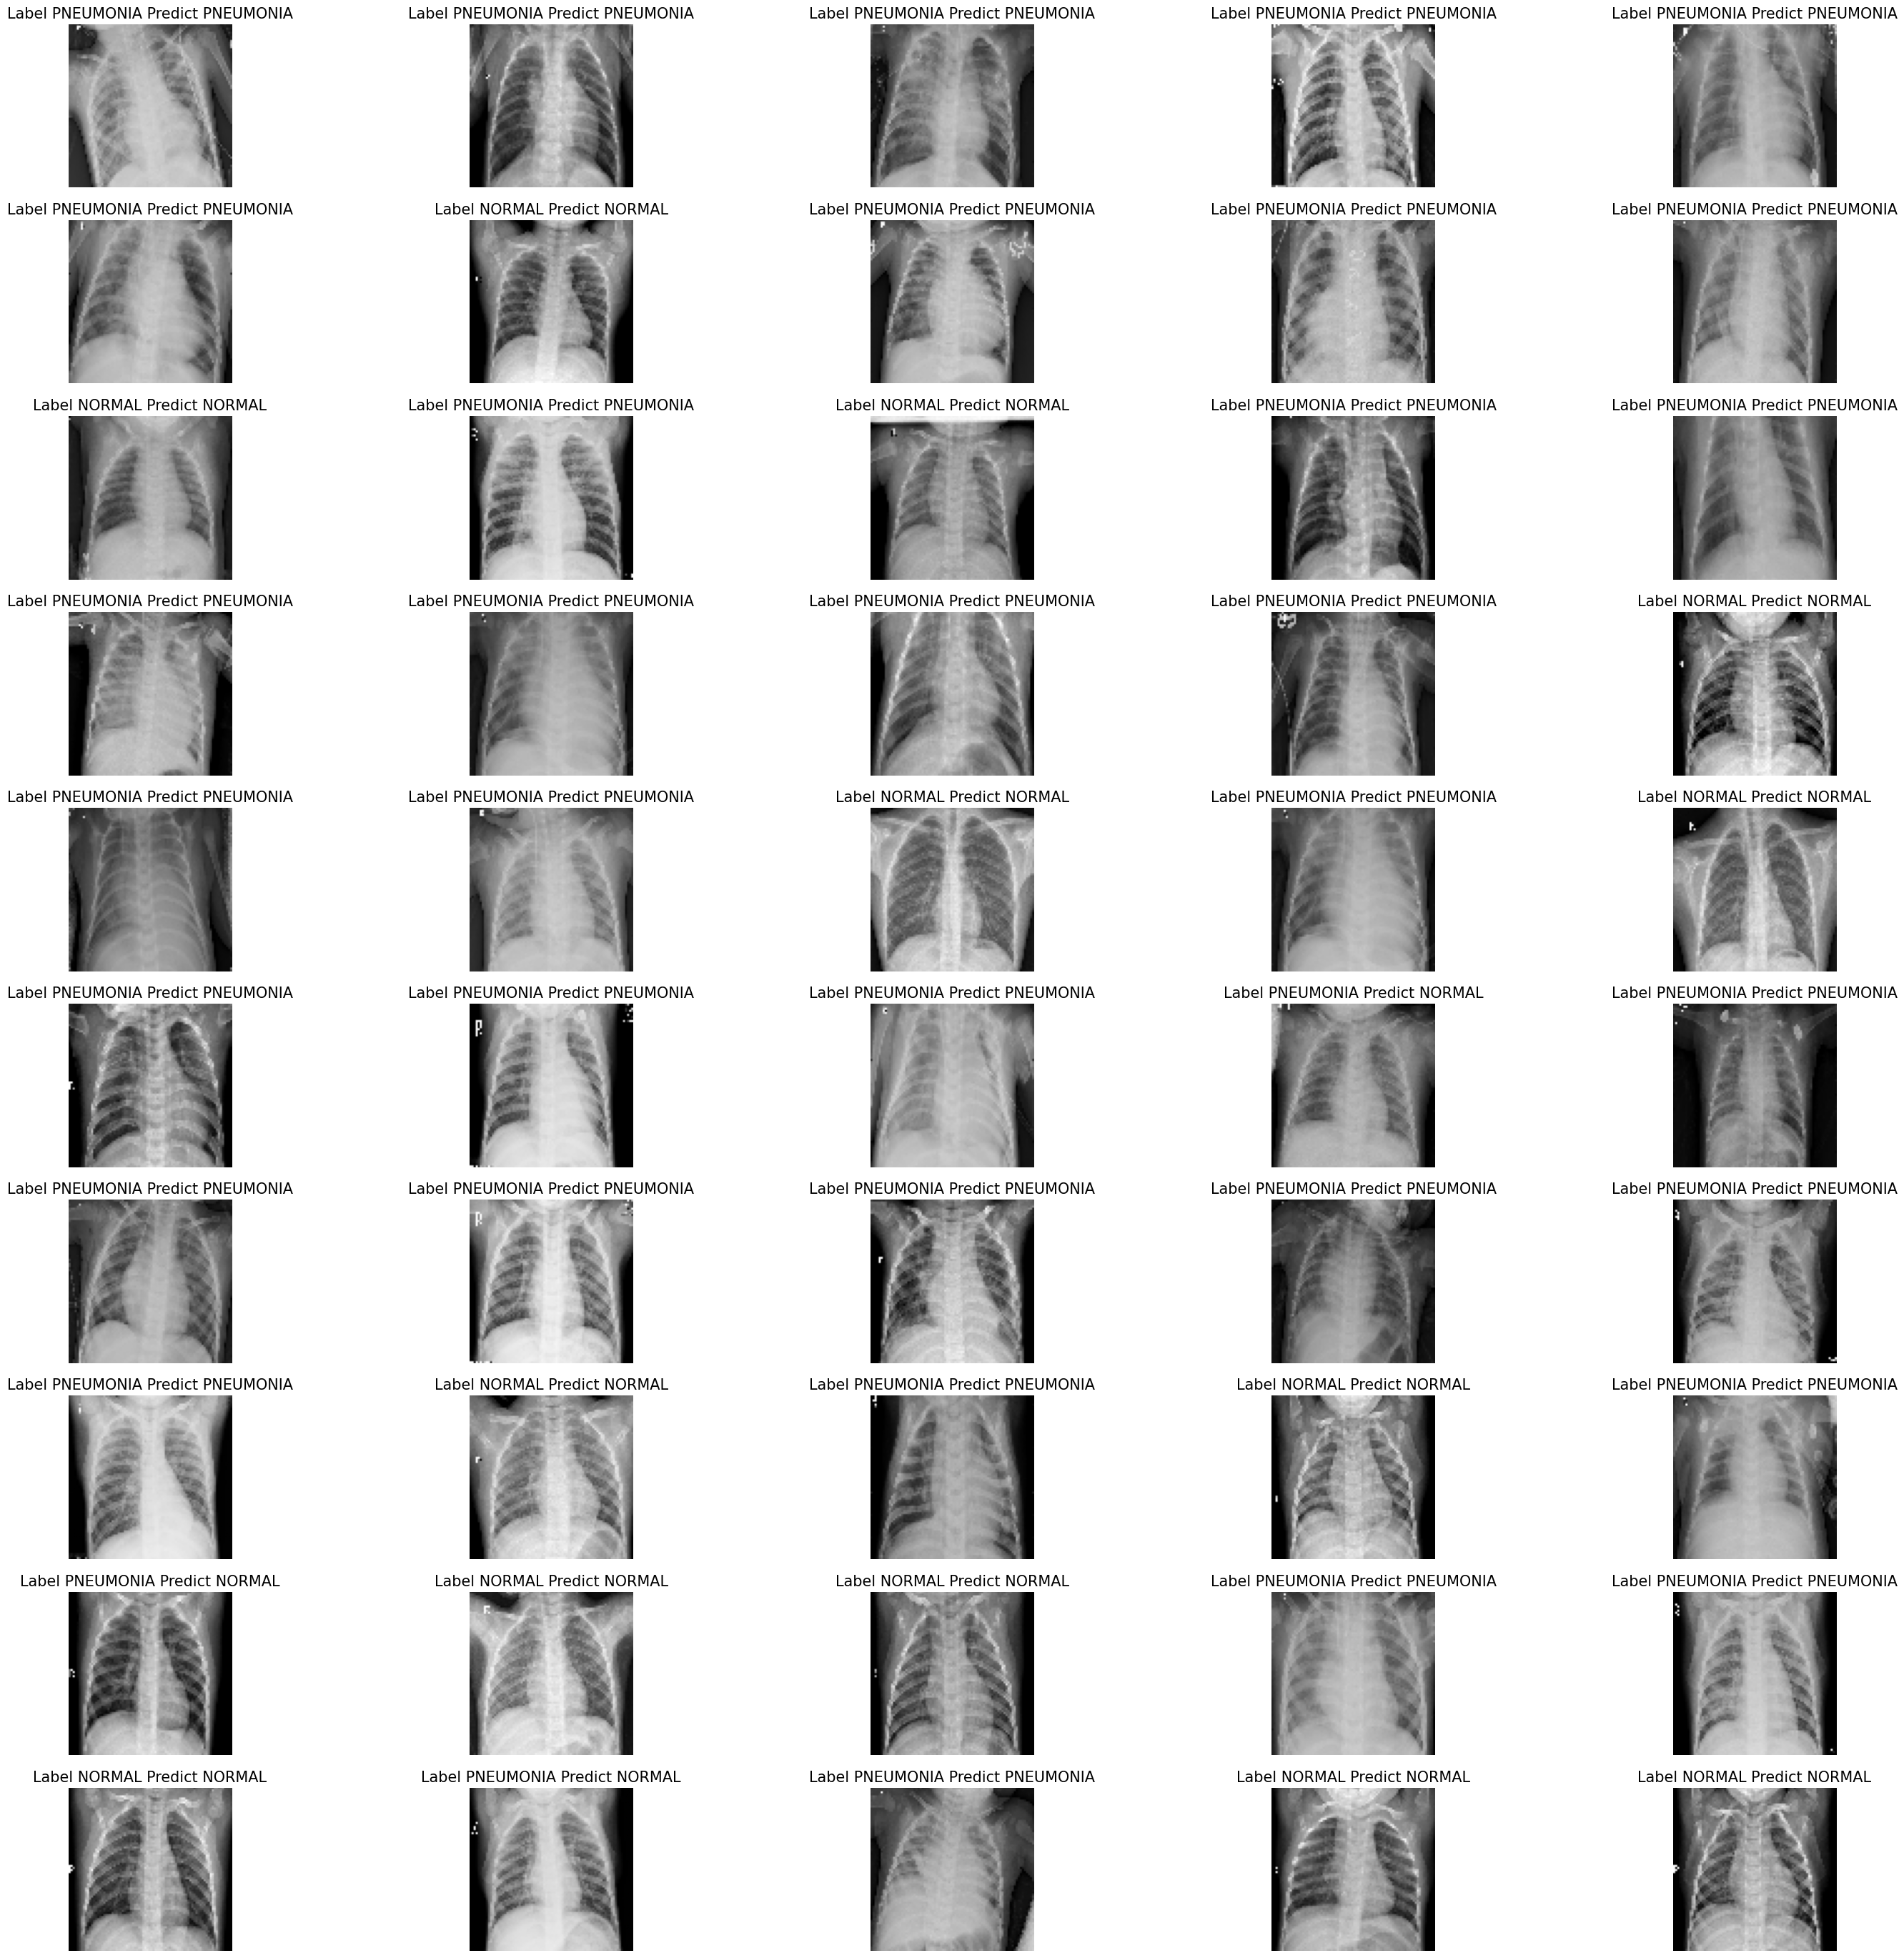

In [23]:
#Show
y_test2=label.inverse_transform(y_test)
y_pred2=label.inverse_transform(y_pred)
plt.figure(figsize=(35,35))
x = 1
for i in np.random.randint(0,len(X_test),50):
    plt.subplot(10, 5, x)
    plt.imshow(X_test[i])
    plt.title(f'Label {y_test2[i]} Predict {y_pred2[i]}', fontsize=15)
    plt.axis('off')    
    x += 1

**Model Check**

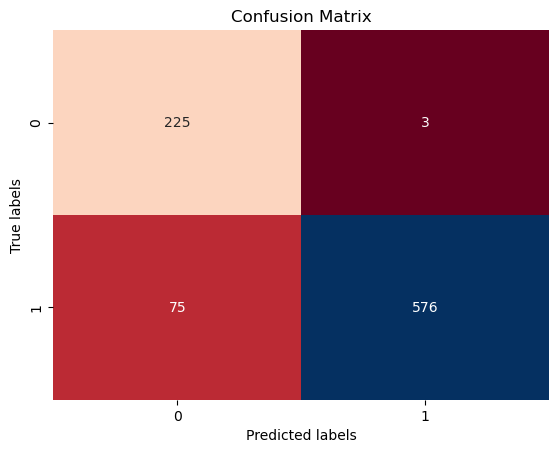

array([[225,   3],
       [ 75, 576]])

In [24]:
ax= plt.subplot()
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [25]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.75      0.99      0.85       228
           1       0.99      0.88      0.94       651

    accuracy                           0.91       879
   macro avg       0.87      0.94      0.89       879
weighted avg       0.93      0.91      0.91       879



# ****Transfer Learning****

In [26]:
base_model = tf.keras.applications.VGG16(input_shape=(Size,Size,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_tr=keras.models.Sequential()
model_tr.add(base_model)
model_tr.add(keras.layers.Flatten()) 
model_tr.add(keras.layers.Dropout(.5))
model_tr.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model_tr.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 14,716,737
Trainable params: 2,049
Non-trainable params: 14,714,688
_________________________________________________________________


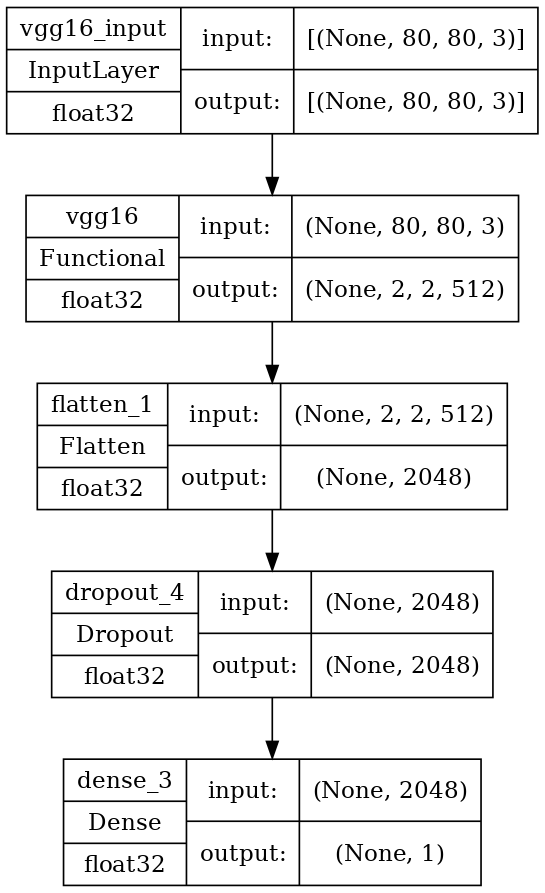

In [27]:
tf.keras.utils.plot_model(model_tr, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [28]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model_tr.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist=model_tr.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10
129/129 [==============================] - 7s 38ms/step - loss: 0.4029 - accuracy: 0.8300 - val_loss: 0.2428 - val_accuracy: 0.9328
Epoch 2/10
129/129 [==============================] - 4s 30ms/step - loss: 0.2553 - accuracy: 0.9041 - val_loss: 0.1876 - val_accuracy: 0.9374
Epoch 3/10
129/129 [==============================] - 4s 30ms/step - loss: 0.2242 - accuracy: 0.9131 - val_loss: 0.1697 - val_accuracy: 0.9408
Epoch 4/10
129/129 [==============================] - 4s 29ms/step - loss: 0.2072 - accuracy: 0.9202 - val_loss: 0.1643 - val_accuracy: 0.9465
Epoch 5/10
129/129 [==============================] - 4s 29ms/step - loss: 0.2024 - accuracy: 0.9256 - val_loss: 0.1508 - val_accuracy: 0.9453
Epoch 6/10
129/129 [==============================] - 4s 29ms/step - loss: 0.1842 - accuracy: 0.9300 - val_loss: 0.1487 - val_accuracy: 0.9487
Epoch 7/10
129/129 [==============================] - 4s 29ms/step - loss: 0.1842 - accuracy: 0.9300 - val_loss: 0.1460 - val_accuracy: 0.9476

In [29]:
score, acc = model_tr.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

28/28 [==============================] - 1s 42ms/step - loss: 0.1746 - accuracy: 0.9283
Test Loss = 0.17461350560188293
Test Accuracy = 0.9283276200294495


In [30]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.402886  0.829958  0.242767      0.932802
1  0.255326  0.904123  0.187606      0.937358
2  0.224234  0.913150  0.169690      0.940775
3  0.207241  0.920224  0.164333      0.946469
4  0.202434  0.925592  0.150771      0.945330
5  0.184191  0.929983  0.148682      0.948747
6  0.184169  0.929983  0.145961      0.947608
7  0.176261  0.936082  0.139238      0.948747
8  0.177096  0.933886  0.139550      0.947608
9  0.179519  0.927787  0.137047      0.947608

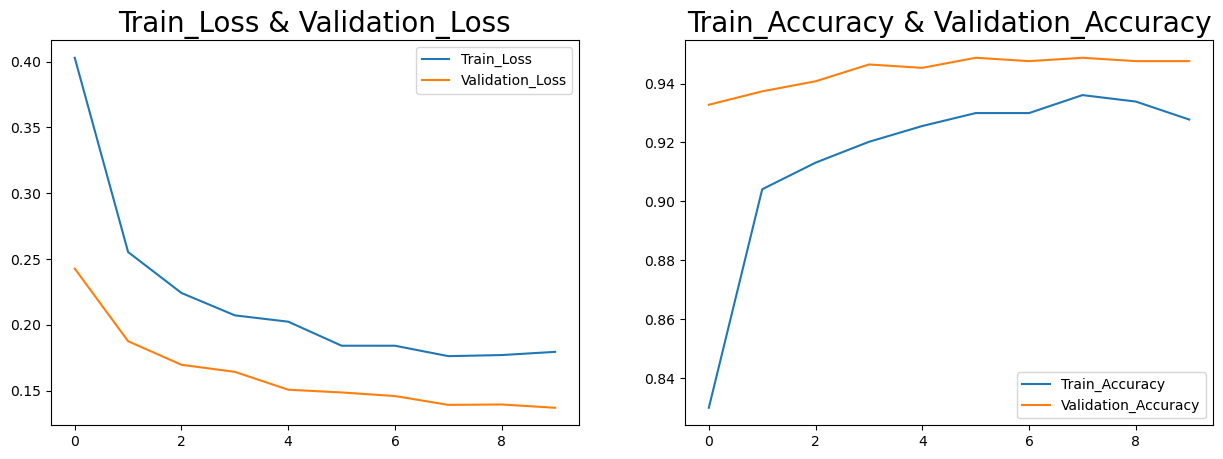

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [32]:
prediction = model_tr.predict(X_test)
prediction[0]

28/28 [==============================] - 1s 24ms/step


array([0.47610012], dtype=float32)

In [33]:
y_pred=np.where(prediction>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=label.inverse_transform(y_test),label.inverse_transform(y_pred)
df

Actual Prediction
0    PNEUMONIA     NORMAL
1    PNEUMONIA  PNEUMONIA
2       NORMAL     NORMAL
3    PNEUMONIA  PNEUMONIA
4    PNEUMONIA  PNEUMONIA
..         ...        ...
874  PNEUMONIA  PNEUMONIA
875  PNEUMONIA  PNEUMONIA
876     NORMAL  PNEUMONIA
877     NORMAL     NORMAL
878     NORMAL     NORMAL

[879 rows x 2 columns]

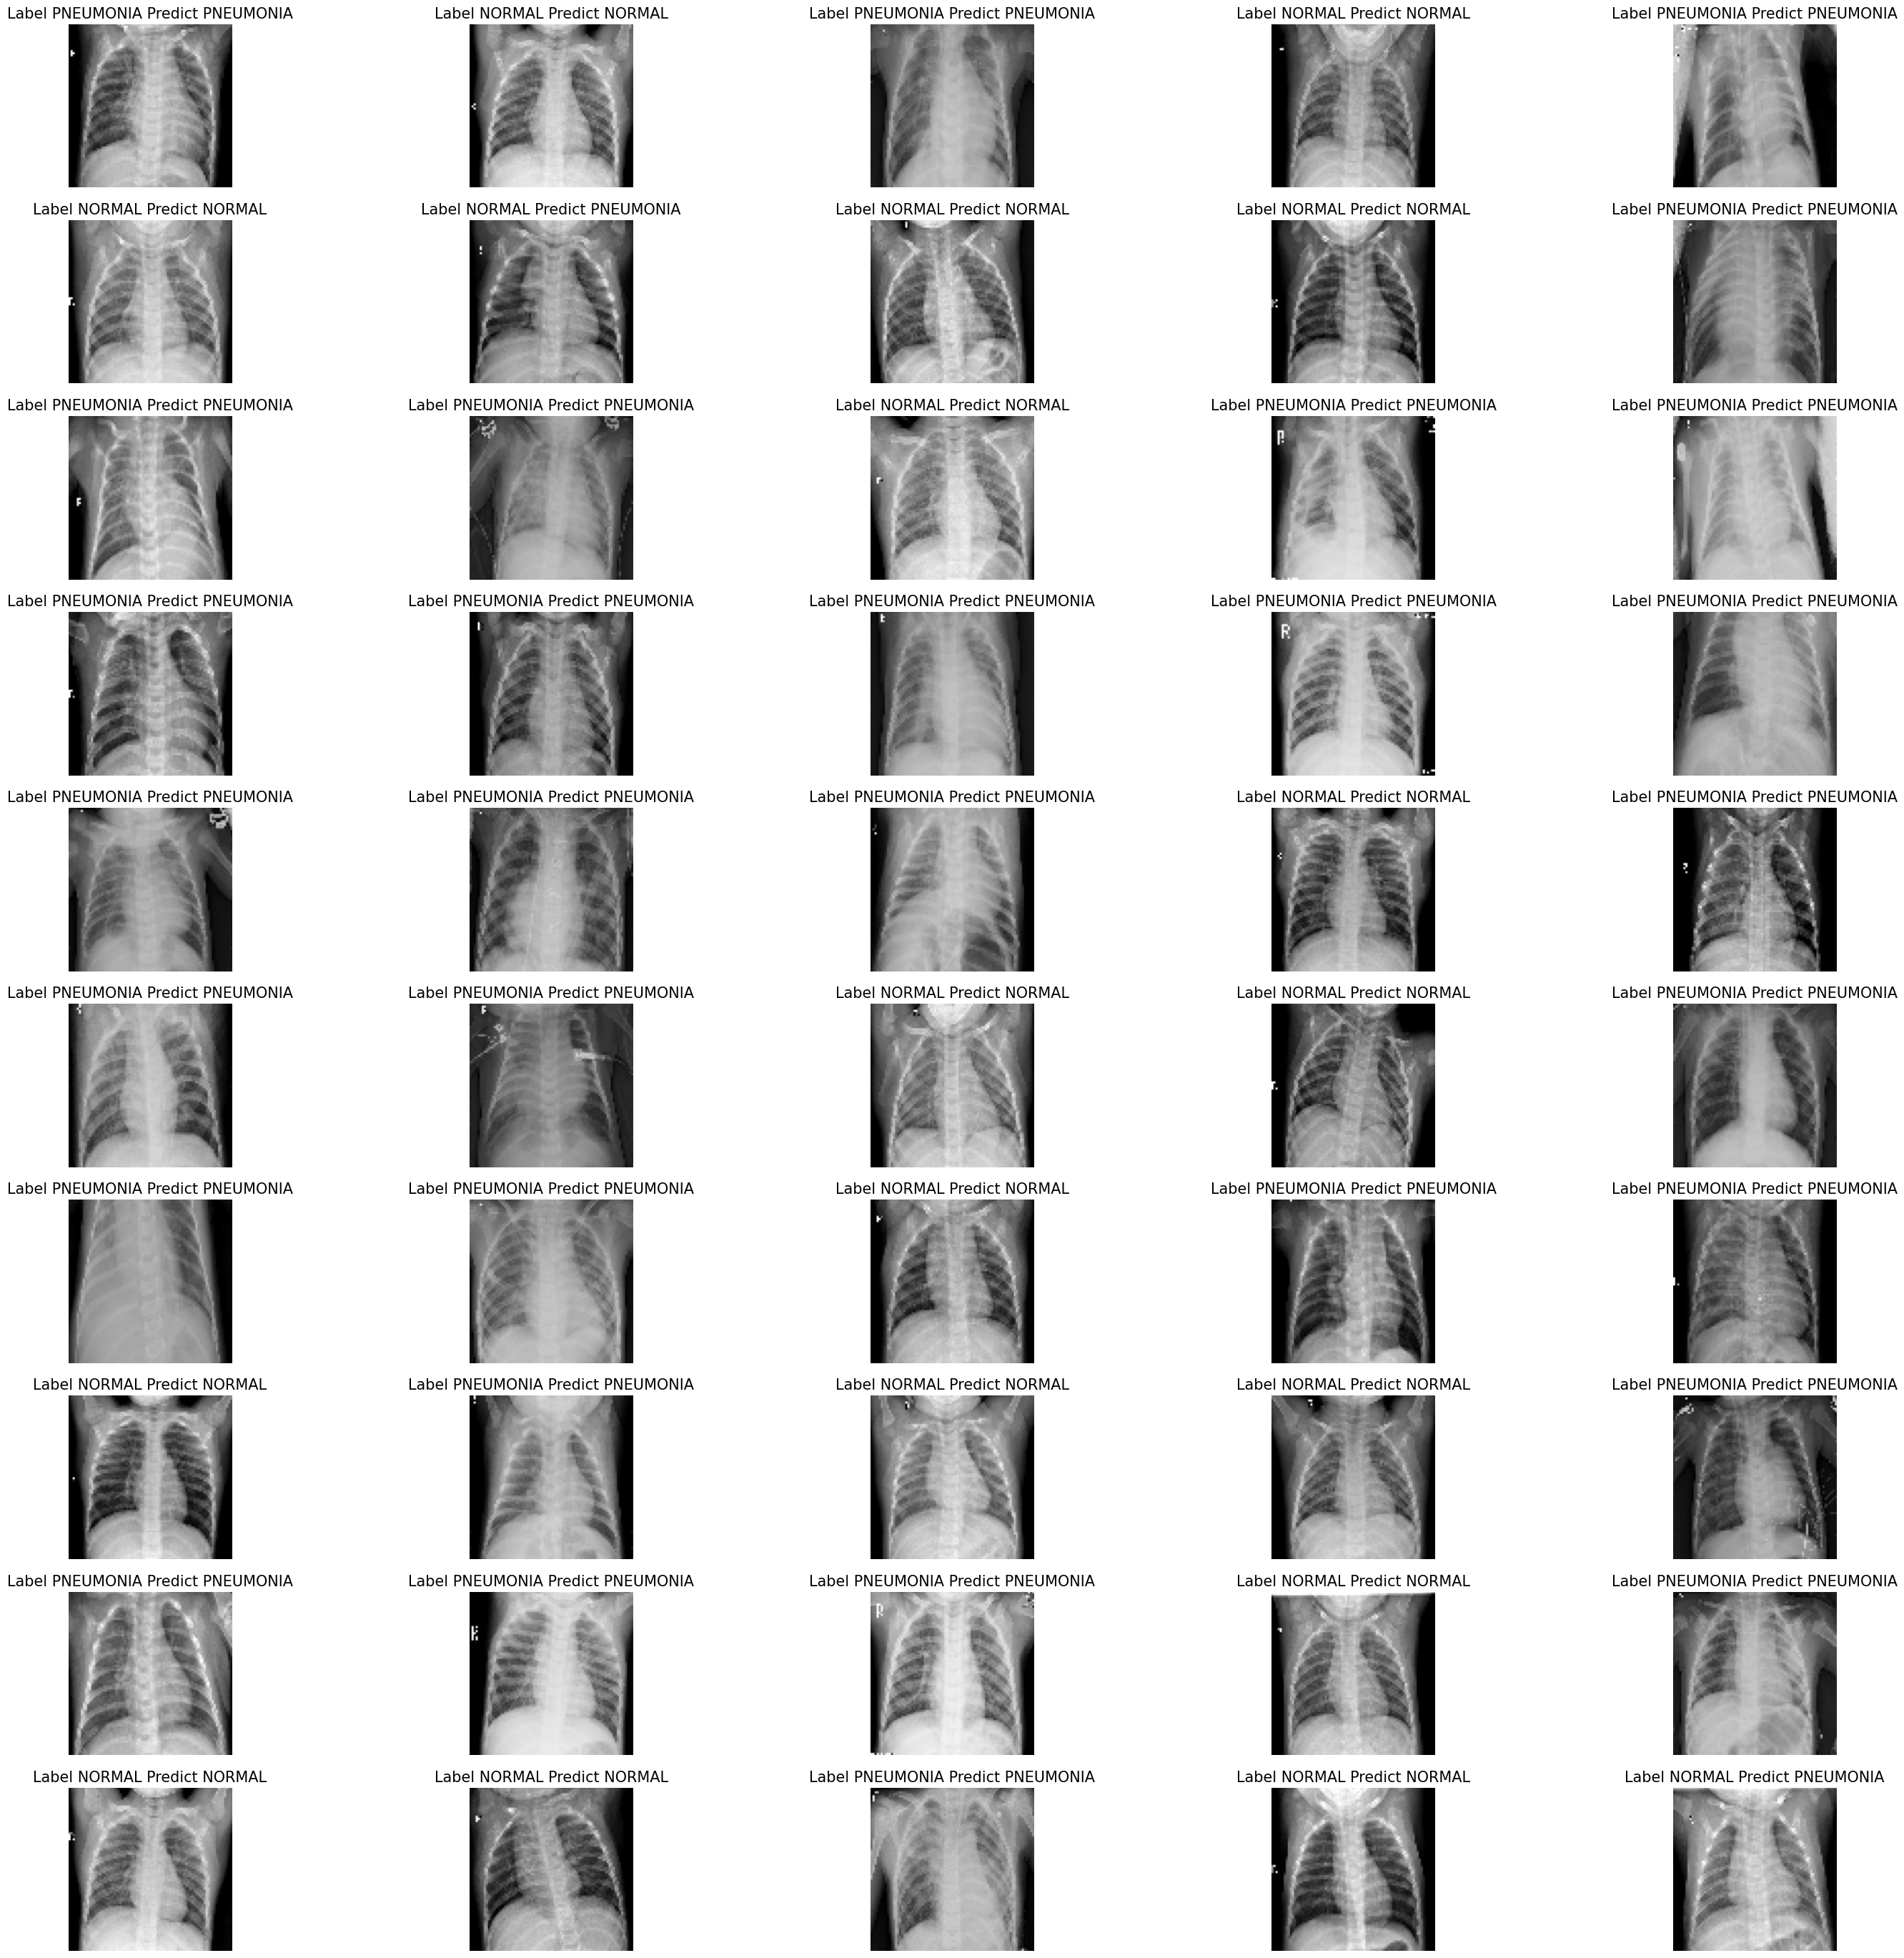

In [34]:
#Show
y_test2=label.inverse_transform(y_test)
y_pred2=label.inverse_transform(y_pred)
plt.figure(figsize=(35,35))
x = 1
for i in np.random.randint(0,len(X_test),50):
    plt.subplot(10, 5, x)
    plt.imshow(X_test[i])
    plt.title(f'Label {y_test2[i]} Predict {y_pred2[i]}', fontsize=15)
    plt.axis('off')    
    x += 1

**Model Check**

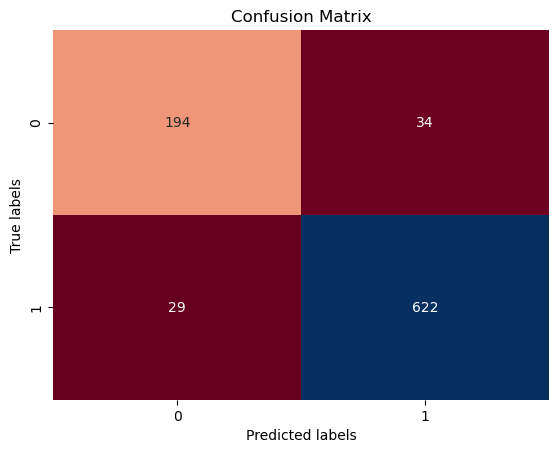

array([[194,  34],
       [ 29, 622]])

In [35]:
ax= plt.subplot()
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [36]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.87      0.85      0.86       228
           1       0.95      0.96      0.95       651

    accuracy                           0.93       879
   macro avg       0.91      0.90      0.91       879
weighted avg       0.93      0.93      0.93       879

